In [30]:
import os
import logging
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
from scipy.stats import entropy
from scipy.stats import wasserstein_distance

In [2]:
app_list = ['Sequence', 'Parallel', 'Choice', 'Map', 'AppMdl']

## Read results

In [3]:
duration_results_aws = pd.DataFrame(columns=['App', 'Value'])
duration_results_model = pd.DataFrame(columns=['App', 'Value'])
cost_results_aws = pd.DataFrame(columns=['App', 'Value'])
cost_results_model = pd.DataFrame(columns=['App', 'Value'])

In [4]:
for app, output, source in itertools.product(app_list, ['duration', 'cost'], ['aws', 'model']):
    data = pd.read_csv(f"../{app}/{app}_{output}_{source}.csv")
    data.columns = ['Value']
    data['App'] = app
    exec(f"{output}_results_{source} = {output}_results_{source}.append(data)")

## Generate plots

In [5]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [6]:
duration_y_lim = {
    "Sequence": (1100, 2500, 250),
    "Parallel": (700, 1400, 200),
    "Choice": (450, 1450, 200),
    "Map": (1400, 2300, 200),
    "AppMdl": (2500, 6000, 250)
}

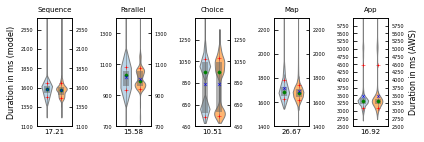

In [102]:
fig, (ax_Sequence, ax_Parallel, ax_Choice, ax_Map, ax_AppMdl) = plt.subplots(nrows=1, ncols=5, figsize=(6, 2))
for app in app_list:
    string = f"""
# plot f{app}
model_duration = duration_results_model.query("App=='{app}'")['Value'].to_list()
aws_duration = duration_results_aws.query("App=='{app}'")['Value'].to_list()
wd = wasserstein_distance(model_duration, aws_duration)
vp_{app} = ax_{app}.violinplot(model_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(model_duration, [10, 25, 50, 75, 90])
mean = np.mean(model_duration)
duration_y1, duration_y2, duration_step = duration_y_lim["{app}"]
whiskers_min, whiskers_max = adjacent_values(np.sort(model_duration), quartile25, quartile75)
ax_{app}.scatter([1.5], medians, marker='o', color='green', s=10, zorder=3, linewidths=0.5)
ax_{app}.scatter([1.5], mean, marker='x', color='blue', s=10, zorder=3, linewidths=0.5)
ax_{app}.scatter([1.5], percentile10, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}.scatter([1.5], percentile90, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_{app}.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)
ax_{app}.set(xlim=(0, 5), xticks=np.arange(0, 5), ylim=(duration_y1, duration_y2), yticks=np.arange(duration_y1, duration_y2, duration_step))
ax_{app}.set_title('{app}', fontsize=7)
#plt.text(x=0.5, y=0.5, s='1', horizontalalignment='center', verticalalignment='center', transform = ax_{app}.transAxes, fontsize=7)


ax_{app}_aws = ax_{app}.twinx()
vp_{app}_twin = ax_{app}_aws.violinplot(
        aws_duration, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(aws_duration, [10, 25, 50, 75, 90])
mean = np.mean(aws_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(aws_duration), quartile25, quartile75)
ax_{app}_aws.scatter([3.5], medians, marker='o', color='green', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.scatter([3.5], mean, marker='x', color='blue', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.scatter([3.5], percentile10, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.scatter([3.5], percentile90, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_{app}_aws.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)
ax_{app}_aws.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(duration_y1, duration_y2), yticks=np.arange(duration_y1, duration_y2, duration_step))
for pc in vp_{app}["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp_{app}_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_{app}.tick_params(axis='both', which='major', labelsize=5)
ax_{app}_aws.tick_params(axis='both', which='major', labelsize=5)
ax_{app}.set_xticklabels([])
ax_{app}_aws.set_xticklabels([])
ax_{app}.tick_params(direction='in', bottom=False)
ax_{app}_aws.tick_params(direction='in', bottom=False)
    """
    exec(string)
ax_AppMdl.set_title('App', fontsize=7)
ax_Sequence.set_ylabel('Duration in ms (model)', fontsize=8)
ax_AppMdl_aws.set_ylabel('Duration in ms (AWS)', fontsize=8)
plt.tight_layout()
for app in app_list:
    string = f"""
model_duration = duration_results_model.query("App=='{app}'")['Value'].to_list()
aws_duration = duration_results_aws.query("App=='{app}'")['Value'].to_list()
wd = wasserstein_distance(model_duration, aws_duration)
plt.text(x=0.5, y=-0.05, s=round(wd, 2), horizontalalignment='center', verticalalignment='center', transform = ax_{app}.transAxes, fontsize=7)
"""
    exec(string)
fig.savefig("mdl_evaluation_results_duration.pdf")

In [9]:
cost_y_lim = {
    "Sequence": (23, 43, 3),
    "Parallel": (22, 42, 2),
    "Choice": (5, 30, 2.5),
    "Map": (300, 400, 10),
    "AppMdl": (95, 205, 10)
}

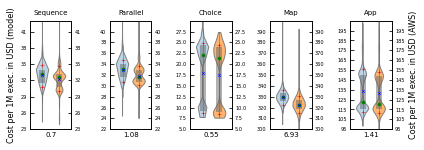

In [103]:
fig, (ax_Sequence, ax_Parallel, ax_Choice, ax_Map, ax_AppMdl) = plt.subplots(nrows=1, ncols=5, figsize=(6, 2))
for app in app_list:
    string = f"""
# plot f{app}
model_cost = cost_results_model.query("App=='{app}'")['Value'].to_list()
aws_cost = cost_results_aws.query("App=='{app}'")['Value'].to_list()
vp_{app} = ax_{app}.violinplot(model_cost, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(model_cost, [10, 25, 50, 75, 90])
mean = np.mean(model_cost)
cost_y1, cost_y2, cost_step = cost_y_lim["{app}"]
whiskers_min, whiskers_max = adjacent_values(np.sort(model_cost), quartile25, quartile75)
ax_{app}.scatter([1.5], medians, marker='o', color='green', s=10, zorder=3, linewidths=0.5)
ax_{app}.scatter([1.5], mean, marker='x', color='blue', s=10, zorder=3, linewidths=0.5)
ax_{app}.scatter([1.5], percentile10, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}.scatter([1.5], percentile90, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_{app}.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)
ax_{app}.set(xlim=(0, 5), xticks=np.arange(0, 5), ylim=(cost_y1, cost_y2), yticks=np.arange(cost_y1, cost_y2, cost_step))
ax_{app}.set_title('{app}', fontsize=7)

ax_{app}_aws = ax_{app}.twinx()
vp_{app}_twin = ax_{app}_aws.violinplot(
        aws_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(aws_cost, [10, 25, 50, 75, 90])
mean = np.mean(aws_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(aws_cost), quartile25, quartile75)
ax_{app}_aws.scatter([3.5], medians, marker='o', color='green', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.scatter([3.5], mean, marker='x', color='blue', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.scatter([3.5], percentile10, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.scatter([3.5], percentile90, marker='+', color='red', s=10, zorder=3, linewidths=0.5)
ax_{app}_aws.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_{app}_aws.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)
ax_{app}_aws.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(cost_y1, cost_y2), yticks=np.arange(cost_y1, cost_y2, cost_step))
for pc in vp_{app}["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp_{app}_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_{app}.tick_params(axis='both', which='major', labelsize=5)
ax_{app}_aws.tick_params(axis='both', which='major', labelsize=5)
ax_{app}.set_xticklabels([])
ax_{app}_aws.set_xticklabels([])
ax_{app}.tick_params(direction='in', bottom=False)
ax_{app}_aws.tick_params(direction='in', bottom=False)
    """
    exec(string)
ax_AppMdl.set_title('App', fontsize=7)
ax_Sequence.set_ylabel('Cost per 1M exec. in USD (model)', fontsize=8)
ax_AppMdl_aws.set_ylabel('Cost per 1M exec. in USD (AWS)', fontsize=8)
plt.tight_layout()
for app in app_list:
    string = f"""
model_cost = cost_results_model.query("App=='{app}'")['Value'].to_list()
aws_cost = cost_results_aws.query("App=='{app}'")['Value'].to_list()
wd = wasserstein_distance(model_cost, aws_cost)
plt.text(x=0.5, y=-0.05, s=round(wd, 2), horizontalalignment='center', verticalalignment='center', transform = ax_{app}.transAxes, fontsize=7)
"""
    exec(string)
fig.savefig("mdl_evaluation_results_cost.pdf")

## Experimental results

In [13]:
from IPython.display import Markdown, display

In [14]:
duration_mean_accuracy = []
duration_median_accuracy = []
duration_percentile10_accuracy = []
duration_percentile90_accuracy = []
cost_mean_accuracy = []
cost_median_accuracy = []
cost_percentile10_accuracy = []
cost_percentile90_accuracy = []
for app in app_list:
    display(Markdown(f"### {app}"))
    display(Markdown(f"#### {'Duration'}"))
    mean_model = duration_results_model.query(f"""App=='{app}'""")['Value'].mean()
    mean_aws = duration_results_aws.query(f"""App=='{app}'""")['Value'].mean()
    median_model = duration_results_model.query(f"""App=='{app}'""")['Value'].median()
    median_aws = duration_results_aws.query(f"""App=='{app}'""")['Value'].median()
    percentile_90_model = np.percentile(duration_results_model.query(f"""App=='{app}'""")['Value'], 90)
    percentile_90_aws = np.percentile(duration_results_aws.query(f"""App=='{app}'""")['Value'], 90)
    percentile_10_model = np.percentile(duration_results_model.query(f"""App=='{app}'""")['Value'], 10)
    percentile_10_aws = np.percentile(duration_results_aws.query(f"""App=='{app}'""")['Value'], 10)
    mean_accuracy = (mean_model - mean_aws) / mean_aws * 100
    median_accuracy = (median_model - median_aws) / median_aws * 100
    percentile90_accuracy = (percentile_90_model - percentile_90_aws) / percentile_90_aws * 100
    percentile10_accuracy = (percentile_10_model - percentile_10_aws) / percentile_10_aws * 100
    duration_mean_accuracy.append(mean_accuracy)
    duration_median_accuracy.append(median_accuracy)
    duration_percentile10_accuracy.append(percentile10_accuracy)
    duration_percentile90_accuracy.append(percentile90_accuracy)
    print(f"The average duration derived by the modeling algorithm", mean_model)
    print(f"The average duration reported by AWS", mean_aws)
    print(f"Diff {(mean_model - mean_aws) / mean_aws * 100}%")
    print(f"The median of duration derived by the modeling algorithm", median_model)
    print(f"The median of duration reported by AWS", median_aws)
    print(f"Diff {(median_model - median_aws) / median_aws * 100}%")
    print(f"The 90th percentile of duration derived by the modeling algorithm", percentile_90_model)
    print(f"The 90th percentile of duration reported by AWS", percentile_90_aws)
    print(f"Diff {(percentile_90_model - percentile_90_aws) / percentile_90_aws * 100}%")
    print(f"The 10th percentile of duration derived by the modeling algorithm", percentile_10_model)
    print(f"The 10th percentile of duration reported by AWS", percentile_10_aws)
    print(f"Diff {(percentile_10_model - percentile_10_aws) / percentile_10_aws * 100}%")
    display(Markdown(f"#### {'Cost'}"))
    mean_model = cost_results_model.query(f"""App=='{app}'""")['Value'].mean()
    mean_aws = cost_results_aws.query(f"""App=='{app}'""")['Value'].mean()
    median_model = cost_results_model.query(f"""App=='{app}'""")['Value'].median()
    median_aws = cost_results_aws.query(f"""App=='{app}'""")['Value'].median()
    percentile_90_model = np.percentile(cost_results_model.query(f"""App=='{app}'""")['Value'], 90)
    percentile_90_aws = np.percentile(cost_results_aws.query(f"""App=='{app}'""")['Value'], 90)
    percentile_10_model = np.percentile(cost_results_model.query(f"""App=='{app}'""")['Value'], 10)
    percentile_10_aws = np.percentile(cost_results_aws.query(f"""App=='{app}'""")['Value'], 10)
    mean_accuracy = (mean_model - mean_aws) / mean_aws * 100
    median_accuracy = (median_model - median_aws) / median_aws * 100
    percentile90_accuracy = (percentile_90_model - percentile_90_aws) / percentile_90_aws * 100
    percentile10_accuracy = (percentile_10_model - percentile_10_aws) / percentile_10_aws * 100
    cost_mean_accuracy.append(mean_accuracy)
    cost_median_accuracy.append(median_accuracy)
    cost_percentile10_accuracy.append(percentile10_accuracy)
    cost_percentile90_accuracy.append(percentile90_accuracy)
    print(f"The average cost derived by the modeling algorithm", mean_model)
    print(f"The average cost reported by AWS", mean_aws)
    print(f"Diff {(mean_model - mean_aws) / mean_aws * 100}%")
    print(f"The median of cost derived by the modeling algorithm", median_model)
    print(f"The median of cost reported by AWS", median_aws)
    print(f"Diff {(median_model - median_aws) / median_aws * 100}%")
    print(f"The 90th percentile of cost derived by the modeling algorithm", percentile_90_model)
    print(f"The 90th percentile of cost reported by AWS", percentile_90_aws)
    print(f"Diff {(percentile_90_model - percentile_90_aws) / percentile_90_aws * 100}%")
    print(f"The 10th percentile of cost derived by the modeling algorithm", percentile_10_model)
    print(f"The 10th percentile of cost reported by AWS", percentile_10_aws)
    print(f"Diff {(percentile_10_model - percentile_10_aws) / percentile_10_aws * 100}%")

### Sequence

#### Duration

The average duration derived by the modeling algorithm 1580.8224330443036
The average duration reported by AWS 1563.7534010410309
Diff 1.0915424383351877%
The median of duration derived by the modeling algorithm 1581.2000801086424
The median of duration reported by AWS 1569.999933242798
Diff 0.7133851810242231%
The 90th percentile of duration derived by the modeling algorithm 1666.0011735687256
The 90th percentile of duration reported by AWS 1658.9999437332153
Diff 0.4220150737169706%
The 10th percentile of duration derived by the modeling algorithm 1482.0801949310305
The 10th percentile of duration reported by AWS 1462.9998207092283
Diff 1.3041952535956232%


#### Cost

The average cost derived by the modeling algorithm 32.961944136259625
The average cost reported by AWS 32.2608600049275
Diff 2.1731724796705376%
The median of cost derived by the modeling algorithm 33.1500647
The median of cost reported by AWS 32.547459328125
Diff 1.8514667022082292%
The 90th percentile of cost derived by the modeling algorithm 34.781317962500005
The 90th percentile of cost reported by AWS 34.588921744375
Diff 0.5562365301436233%
The 10th percentile of cost derived by the modeling algorithm 30.724018181250003
The 10th percentile of cost reported by AWS 30.0029750725
Diff 2.403238702187548%


### Parallel

#### Duration

The average duration derived by the modeling algorithm 1021.202376398526
The average duration reported by AWS 1006.2184027194977
Diff 1.489137312389758%
The median of duration derived by the modeling algorithm 1034.3400400543214
The median of duration reported by AWS 993.000030517578
Diff 4.163142826410177%
The 90th percentile of duration derived by the modeling algorithm 1082.1610732421877
The 90th percentile of duration reported by AWS 1079.9999237060547
Diff 0.2001064526668667%
The 10th percentile of duration derived by the modeling algorithm 937.1900417709351
The 10th percentile of duration reported by AWS 939.000129699707
Diff -0.1927675909215083%


#### Cost

The average cost derived by the modeling algorithm 32.96236226209587
The average cost reported by AWS 31.88067445289125
Diff 3.3929263661061784%
The median of cost derived by the modeling algorithm 33.1604813875
The median of cost reported by AWS 31.64068668125
Diff 4.8032924239618895%
The 90th percentile of cost derived by the modeling algorithm 34.77090127500001
The 90th percentile of cost reported by AWS 33.734545035625
Diff 3.072091941007586%
The 10th percentile of cost derived by the modeling algorithm 30.73860154375
The 10th percentile of cost reported by AWS 30.19485045625
Diff 1.8008073538494767%


### Choice

#### Duration

The average duration derived by the modeling algorithm 839.1593221855803
The average duration reported by AWS 843.1199994564056
Diff -0.46976436015975004%
The median of duration derived by the modeling algorithm 947.6948874664307
The median of duration reported by AWS 948.9998817443848
Diff -0.13751258593997956%
The 90th percentile of duration derived by the modeling algorithm 1068.16003528595
The 90th percentile of duration reported by AWS 1082.0000171661377
Diff -1.279111059206443%
The 10th percentile of duration derived by the modeling algorithm 538.9600589370727
The 10th percentile of duration reported by AWS 549.0000247955322
Diff -1.828773297815193%


#### Cost

The average cost derived by the modeling algorithm 17.93785645064275
The average cost reported by AWS 17.526224044046252
Diff 2.3486656655877525%
The median of cost derived by the modeling algorithm 22.02504325
The median of cost reported by AWS 21.437542075000003
Diff 2.740524883611202%
The 90th percentile of cost derived by the modeling algorithm 24.891715650000005
The 90th percentile of cost reported by AWS 24.450464767500005
Diff 1.8046727810528937%
The 10th percentile of cost derived by the modeling algorithm 8.662516525000001
The 10th percentile of cost reported by AWS 8.438453576875
Diff 2.6552607783377487%


### Map

#### Duration

The average duration derived by the modeling algorithm 1717.6143628537095
The average duration reported by AWS 1693.0984003067017
Diff 1.4479939584472337%
The median of duration derived by the modeling algorithm 1683.3201239776608
The median of duration reported by AWS 1677.0000457763672
Diff 0.3768680995096678%
The 90th percentile of duration derived by the modeling algorithm 1783.8101707077028
The 90th percentile of duration reported by AWS 1746.000051498413
Diff 2.165527954987239%
The 10th percentile of duration derived by the modeling algorithm 1629.9186782302859
The 10th percentile of duration reported by AWS 1615.0000095367432
Diff 0.9237565699966823%


#### Cost

The average cost derived by the modeling algorithm 329.6629424495982
The average cost reported by AWS 322.729971961885
Diff 2.148226409083563%
The median of cost derived by the modeling algorithm 329.36418439375007
The median of cost reported by AWS 322.76156702187507
Diff 2.0456640587035904%
The 90th percentile of cost derived by the modeling algorithm 336.29961493124995
The 90th percentile of cost reported by AWS 330.60720771312504
Diff 1.7218037251820404%
The 10th percentile of cost derived by the modeling algorithm 322.49219148312505
The 10th percentile of cost reported by AWS 314.931343028125
Diff 2.400792624291072%


### AppMdl

#### Duration

The average duration derived by the modeling algorithm 3481.3801966017204
The average duration reported by AWS 3482.393802547455
Diff -0.029106585963742767%
The median of duration derived by the modeling algorithm 3313.209970436096
The median of duration reported by AWS 3309.000015258789
Diff 0.12722741486531725%
The 90th percentile of duration derived by the modeling algorithm 4466.090224876404
The 90th percentile of duration reported by AWS 4466.100072860718
Diff -0.0002205052317004933%
The 10th percentile of duration derived by the modeling algorithm 3089.8916997833244
The 10th percentile of duration reported by AWS 3099.9999046325684
Diff -0.32607113420031103%


#### Cost

The average cost derived by the modeling algorithm 133.26451374483406
The average cost reported by AWS 131.88937225460123
Diff 1.0426476877744486%
The median of cost derived by the modeling algorithm 122.66846330312501
The median of cost reported by AWS 120.565333696875
Diff 1.7443899848837892%
The 90th percentile of cost derived by the modeling algorithm 155.7523820375
The 90th percentile of cost reported by AWS 152.83300119874997
Diff 1.9101770009433812%
The 10th percentile of cost derived by the modeling algorithm 112.2168795
The 10th percentile of cost reported by AWS 111.80614959187496
Diff 0.36735895979275984%


In [15]:
def process_accuracy(l):
    return np.mean([100 - np.abs(e) for e in l])

In [16]:
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the average duration: {process_accuracy(duration_mean_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the median of duration: {process_accuracy(duration_median_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the 10th percentile of duration: {process_accuracy(duration_percentile10_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the 90th percentile duration: {process_accuracy(duration_percentile90_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the average cost: {process_accuracy(cost_mean_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the median of cost: {process_accuracy(cost_median_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the 10th percentile of cost: {process_accuracy(cost_percentile10_accuracy)}%")
print(f"The average accuracy of the performance and cost modeling algorithm when modeling the 90th percentile cost: {process_accuracy(cost_percentile90_accuracy)}%")

The average accuracy of the performance and cost modeling algorithm when modeling the average duration: 99.09449106894087%
The average accuracy of the performance and cost modeling algorithm when modeling the median of duration: 98.89637277845011%
The average accuracy of the performance and cost modeling algorithm when modeling the 10th percentile of duration: 99.08488723069415%
The average accuracy of the performance and cost modeling algorithm when modeling the 90th percentile duration: 99.18660379083815%
The average accuracy of the performance and cost modeling algorithm when modeling the average cost: 97.77887227835551%
The average accuracy of the performance and cost modeling algorithm when modeling the median of cost: 97.36293238932625%
The average accuracy of the performance and cost modeling algorithm when modeling the 10th percentile of cost: 98.07450831630828%
The average accuracy of the performance and cost modeling algorithm when modeling the 90th percentile cost: 98.187003

In [35]:
wasserstein_distance(duration_results_model.query(f"App == '{'Sequence'}'")['Value'].to_list(), duration_results_aws.query(f"App == '{'Sequence'}'")['Value'].to_list())

17.21186737058091

In [37]:
wasserstein_distance(duration_results_model.query(f"App == '{'Parallel'}'")['Value'].to_list(), duration_results_aws.query(f"App == '{'Parallel'}'")['Value'].to_list())

15.584561918855908

In [38]:
wasserstein_distance(duration_results_model.query(f"App == '{'Choice'}'")['Value'].to_list(), duration_results_aws.query(f"App == '{'Choice'}'")['Value'].to_list())

10.51218927641265

In [39]:
wasserstein_distance(duration_results_model.query(f"App == '{'Map'}'")['Value'].to_list(), duration_results_aws.query(f"App == '{'Map'}'")['Value'].to_list())

26.671597456137675

In [40]:
wasserstein_distance(duration_results_model.query(f"App == '{'AppMdl'}'")['Value'].to_list(), duration_results_aws.query(f"App == '{'AppMdl'}'")['Value'].to_list())

16.92177300075988

In [42]:
wasserstein_distance(cost_results_model.query(f"App == '{'Sequence'}'")['Value'].to_list(), cost_results_aws.query(f"App == '{'Sequence'}'")['Value'].to_list())

0.701342694349247

In [43]:
wasserstein_distance(cost_results_model.query(f"App == '{'Parallel'}'")['Value'].to_list(), cost_results_aws.query(f"App == '{'Parallel'}'")['Value'].to_list())

1.0817266009488855

In [44]:
wasserstein_distance(cost_results_model.query(f"App == '{'Choice'}'")['Value'].to_list(), cost_results_aws.query(f"App == '{'Choice'}'")['Value'].to_list())

0.554599942530995

In [53]:
wasserstein_distance(cost_results_model.query(f"App == '{'Map'}'")['Value'].to_list(), cost_results_aws.query(f"App == '{'Map'}'")['Value'].to_list())

6.932970487713247

In [46]:
wasserstein_distance(cost_results_model.query(f"App == '{'AppMdl'}'")['Value'].to_list(), cost_results_aws.query(f"App == '{'AppMdl'}'")['Value'].to_list())

1.4086039488629418